# Lab 05 - Ensemble Learning

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import xgboost as xgb
from mlxtend.evaluate import bias_variance_decomp # Try to import, might need installation

## Task 1: Ensemble Pipeline (Heart Dataset)

In [3]:
# Load Data
df = pd.read_csv(r"C:\Ali\Programming\MLFall25\Lab05\heart.csv")

# EDA
print("--- EDA ---")
print("Missing Values:", df.isnull().sum().sum())
print("Duplicates:", df.duplicated().sum())
if df.duplicated().sum() > 0:
    df = df.drop_duplicates()

target = 'target' # Assuming 'target' is the label based on standard heart.csv, check if it's 'Label'
if 'Label' in df.columns:
    target = 'Label'
elif 'target' not in df.columns:
    # Fallback or check columns
    print("Columns:", df.columns)
    target = df.columns[-1]

print(f"Target Variable: {target}")
print("Target Balance:")
print(df[target].value_counts())

# Scaling
X = df.drop(columns=[target])
y = df[target]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split: Train 80%, Test 20%
X_train_full, X_test, y_train_full, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=0)

# Validation Split: Train 70%, Val 30% (from Train split)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.3, random_state=0)

print(f"Split Sizes: Train={X_train.shape[0]}, Val={X_val.shape[0]}, Test={X_test.shape[0]}")

# Models
rf = RandomForestClassifier(random_state=0)
xgb_model = xgb.XGBClassifier(random_state=0, use_label_encoder=False, eval_metric='logloss')
ada = AdaBoostClassifier(random_state=0, algorithm='SAMME')

models = {'Random Forest': rf, 'XGBoost': xgb_model, 'AdaBoost': ada}

print("\n--- Model Comparison ---")
for name, model in models.items():
    model.fit(X_train, y_train)
    train_acc = model.score(X_train, y_train)
    test_acc = model.score(X_test, y_test)
    print(f"{name}: Train Acc = {train_acc:.4f}, Test Acc = {test_acc:.4f}")

--- EDA ---
Missing Values: 0
Duplicates: 723
Target Variable: target
Target Balance:
target
1    164
0    138
Name: count, dtype: int64
Split Sizes: Train=168, Val=73, Test=61

--- Model Comparison ---
Random Forest: Train Acc = 1.0000, Test Acc = 0.8033
XGBoost: Train Acc = 1.0000, Test Acc = 0.7869
AdaBoost: Train Acc = 0.9107, Test Acc = 0.7541


c:\Users\Pc\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [00:35:14] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Pc\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(


## Task 2: Voting Classifier (restecg, oldpeak)


--- Voting Classifier (Hard vs Soft) ---
Voting='hard': Accuracy = 0.6066


c:\Users\Pc\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [00:35:14] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Pc\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [00:35:15] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Voting='soft': Accuracy = 0.6230

--- Weight Optimization (Heuristic) ---
Weights=[1, 1, 1, 1]: Accuracy = 0.6230


c:\Users\Pc\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [00:35:15] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Pc\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [00:35:15] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Weights=[1, 1, 2, 2]: Accuracy = 0.6230
Weights=[1, 2, 1, 1]: Accuracy = 0.6066


c:\Users\Pc\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [00:35:15] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Pc\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [00:35:15] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Weights=[2, 1, 1, 1]: Accuracy = 0.6066
Best Weights: [1, 1, 1, 1] with Accuracy: 0.6230

Calculating Bias-Variance Decomposition...


c:\Users\Pc\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [00:35:15] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Pc\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [00:35:16] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Pc\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [00:35:16] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Pc\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [00:35:16] WARNING: C:\actions-runner\_w

MSE: 0.4107
Bias: 0.3154
Variance: 0.0953


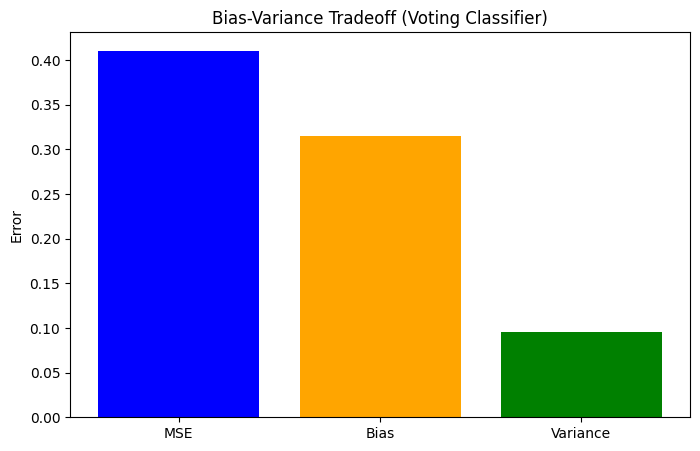

In [4]:
# Extract Attributes
features_t2 = ['restecg', 'oldpeak']
X_t2 = df[features_t2]
y_t2 = df[target]

# Split (using same random state for consistency)
X_train_t2, X_test_t2, y_train_t2, y_test_t2 = train_test_split(X_t2, y_t2, test_size=0.2, random_state=0)

# Models
dt = DecisionTreeClassifier(random_state=0)
knn = KNeighborsClassifier()
rf = RandomForestClassifier(random_state=0)
xgb_model = xgb.XGBClassifier(random_state=0, use_label_encoder=False, eval_metric='logloss')

estimators = [('dt', dt), ('knn', knn), ('rf', rf), ('xgb', xgb_model)]

# Check Voting Parameter (Hard vs Soft)
print("\n--- Voting Classifier (Hard vs Soft) ---")
for voting_type in ['hard', 'soft']:
    vc = VotingClassifier(estimators=estimators, voting=voting_type)
    vc.fit(X_train_t2, y_train_t2)
    acc = vc.score(X_test_t2, y_test_t2)
    print(f"Voting='{voting_type}': Accuracy = {acc:.4f}")

# Check Best Weights (Simple manual check or heuristic)
# For demonstration, we'll try equal weights vs some variations
print("\n--- Weight Optimization (Heuristic) ---")
weights_list = [
    [1, 1, 1, 1], # Equal
    [1, 1, 2, 2], # Favor stronger models (RF, XGB)
    [1, 2, 1, 1], # Favor KNN
    [2, 1, 1, 1]  # Favor DT
]

best_acc = 0
best_weights = None

for w in weights_list:
    vc = VotingClassifier(estimators=estimators, voting='soft', weights=w)
    vc.fit(X_train_t2, y_train_t2)
    acc = vc.score(X_test_t2, y_test_t2)
    print(f"Weights={w}: Accuracy = {acc:.4f}")
    if acc > best_acc:
        best_acc = acc
        best_weights = w

print(f"Best Weights: {best_weights} with Accuracy: {best_acc:.4f}")

# Bias-Variance Tradeoff Graph
# Using mlxtend if available, otherwise manual explanation
try:
    print("\nCalculating Bias-Variance Decomposition...")
    # Note: bias_variance_decomp requires integer labels and numpy arrays
    X_train_np = X_train_t2.values
    X_test_np = X_test_t2.values
    y_train_np = y_train_t2.values
    y_test_np = y_test_t2.values
    
    vc_best = VotingClassifier(estimators=estimators, voting='soft', weights=best_weights)
    
    mse, bias, var = bias_variance_decomp(vc_best, X_train_np, y_train_np, X_test_np, y_test_np, loss='mse', num_rounds=200, random_seed=0)
    
    print(f'MSE: {mse:.4f}')
    print(f'Bias: {bias:.4f}')
    print(f'Variance: {var:.4f}')
    
    # Plotting
    plt.figure(figsize=(8, 5))
    plt.bar(['MSE', 'Bias', 'Variance'], [mse, bias, var], color=['blue', 'orange', 'green'])
    plt.title('Bias-Variance Tradeoff (Voting Classifier)')
    plt.ylabel('Error')
    plt.show()
    
except ImportError:
    print("mlxtend not installed. Skipping Bias-Variance calculation.")
except Exception as e:
    print(f"Error in Bias-Variance decomposition: {e}")

## Task 3: Voting Classifier (restecg, chol)

c:\Users\Pc\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
c:\Users\Pc\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [00:35:47] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Pc\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(


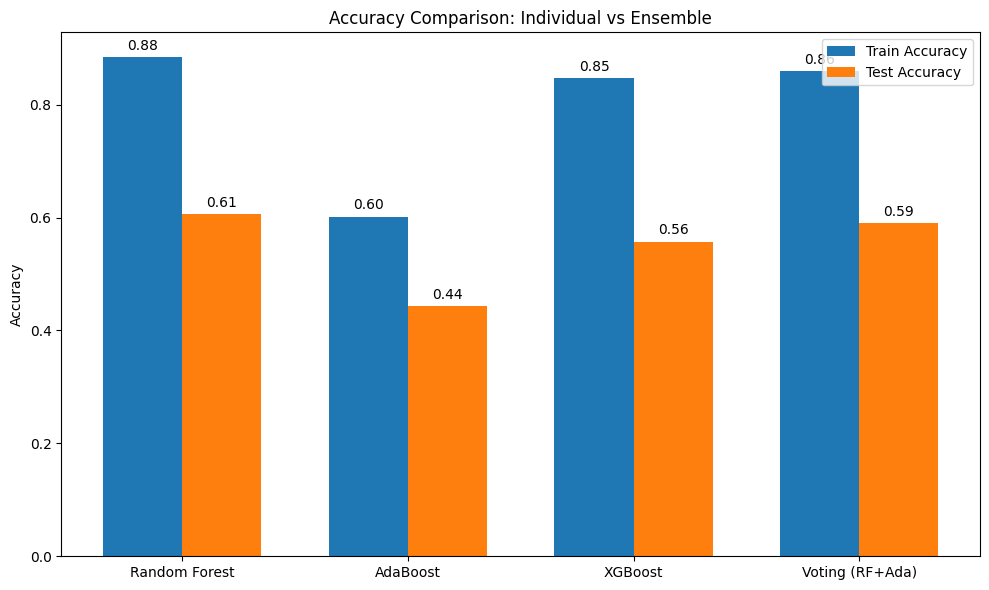

In [5]:
# Extract Attributes
features_t3 = ['restecg', 'chol']
X_t3 = df[features_t3]
y_t3 = df[target]

# Split
X_train_t3, X_test_t3, y_train_t3, y_test_t3 = train_test_split(X_t3, y_t3, test_size=0.2, random_state=0)

# Models
rf = RandomForestClassifier(random_state=0)
ada = AdaBoostClassifier(random_state=0, algorithm='SAMME')
xgb_model = xgb.XGBClassifier(random_state=0, use_label_encoder=False, eval_metric='logloss') # Added for comparison as per prompt implication

# Voting Classifier (RF + AdaBoost)
vc_t3 = VotingClassifier(estimators=[('rf', rf), ('ada', ada)], voting='soft')

# Train and Collect Accuracies
models_t3 = [rf, ada, xgb_model, vc_t3]
names_t3 = ['Random Forest', 'AdaBoost', 'XGBoost', 'Voting (RF+Ada)']
train_accs = []
test_accs = []

for model in models_t3:
    model.fit(X_train_t3, y_train_t3)
    train_accs.append(model.score(X_train_t3, y_train_t3))
    test_accs.append(model.score(X_test_t3, y_test_t3))

# Plotting
x = np.arange(len(names_t3))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, train_accs, width, label='Train Accuracy')
rects2 = ax.bar(x + width/2, test_accs, width, label='Test Accuracy')

ax.set_ylabel('Accuracy')
ax.set_title('Accuracy Comparison: Individual vs Ensemble')
ax.set_xticks(x)
ax.set_xticklabels(names_t3)
ax.legend()

ax.bar_label(rects1, padding=3, fmt='%.2f')
ax.bar_label(rects2, padding=3, fmt='%.2f')

plt.tight_layout()
plt.show()